In [1]:
cd /home

/home


In [2]:
from src.models import get_ASTROMER_II

import os 
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import toml
from src.layers.downstream import AstromerEmbedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.callbacks  import (ModelCheckpoint,
                                         EarlyStopping,
                                         TensorBoard)
from src.models import get_ASTROMER_II
from src.data import load_data, load_light_curves

%load_ext autoreload
%autoreload 2

2023-07-09 20:00:00.249551: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
pretrain_weights = './presentation/experiments/astromer_2/results/nsp_cond/2_4_64_rmse_0.5/pretraining/'
with open(os.path.join(pretrain_weights, 'config.toml'), 'r') as file:
    config = toml.load(file)

In [4]:
winsize = 200
test_batches = load_data(dataset=os.path.join('./data/records/macho_clean/', 'test'), 
                          batch_size=64, 
                          probed=1,  
                          window_size=winsize, 
                          nsp_prob=.0, 
                          repeat=1, 
                          sampling=False)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-07-09 20:00:02.216915: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: UNKNOWN ERROR (34)
2023-07-09 20:00:02.216950: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (22638d65af23): /proc/driver/nvidia/version does not exist
2023-07-09 20:00:02.217181: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
astromer = get_ASTROMER_II(num_layers=config['layers'],
                           num_heads=config['nh'],
                           head_dim=config['hdim'],
                           mixer_size=config['mixer'],
                           dropout=config['dropout'],
                           pe_base=1000,
                           pe_dim=128,
                           pe_c=1,
                           window_size=config['ws'],
                        encoder_mode=config['encoder_mode'])

astromer.load_weights(os.path.join(pretrain_weights, 'weights')).expect_partial()

# optimizer = AdamW(config['lr'])
# bce_factor = 1.- config['rmse_factor']
# astromer.compile(rmse_factor=config['rmse_factor'], bce_factor=bce_factor, optimizer=optimizer)

# astromer.evaluate(test_batches)

PE_C RECEIVED:  tf.Tensor(1.0, shape=(), dtype=float32)
Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: code mixing tabs and spaces for indentation is not allowed
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [6]:
layer = AstromerEmbedding(pretrain_weights=pretrain_weights)

PE_C RECEIVED:  tf.Tensor(1.0, shape=(), dtype=float32)


In [12]:
test_batches_clf = load_light_curves(os.path.join('./data/records/macho_clean', 'test'), 
                                      num_cls=1,
                                      batch_size=64, 
                                      window_size=winsize, 
                                      repeat=1,
                                      cache=True, 
                                      njobs=None)
for x, y in test_batches_clf:
    
    y_cls, y_rec = layer(x)
    print(y_rec.shape)
    break

(64, 200, 256)


In [8]:
# # model = layer.astromer
# optimizer = AdamW(config['lr'])
# bce_factor    = 1.- config['rmse_factor']
# astromer.compile(rmse_factor=config['rmse_factor'], bce_factor=bce_factor, optimizer=optimizer)
# astromer.evaluate(format_dataset)

(64, 1) (64, 1)


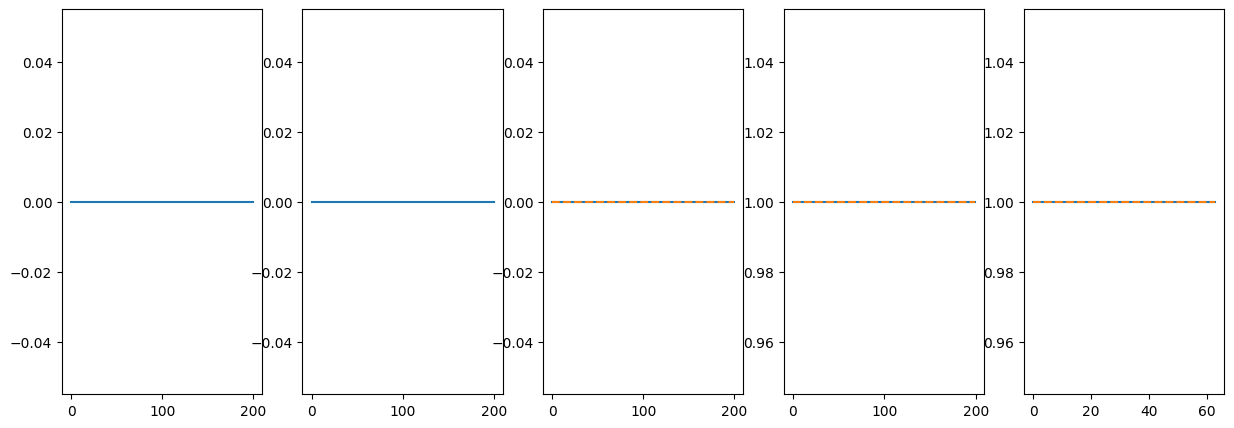

In [9]:

for (x, y), (x_clf, y_clf) in zip(test_batches, format_dataset):
#     x_clf_format = layer.format_input(x_clf)
    fig, axes = plt.subplots(1, 5, figsize=(15,5))
    
    axes[0].plot(x_clf['times'][0]-x['times'][0])
#     axes[0].plot(x['times'][0], linestyle='--')
    
    residuals = x_clf['magnitudes'][0]-x['magnitudes'][0]
    axes[1].plot(residuals)

    axes[2].plot(x_clf['att_mask'][0, :, 0])
    axes[2].plot(x['att_mask'][0, :, 0], linestyle='--')
    
    axes[3].plot(y_clf['probed_mask'][0, :, 0])
    axes[3].plot(y['probed_mask'][0, :, 0], linestyle='--')
    
    print(y_clf['nsp_label'].shape, y['nsp_label'].shape)
    axes[4].plot(y_clf['nsp_label'])
    axes[4].plot(y['nsp_label'], linestyle='--')
    
    break